In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

In [4]:
df = pd.read_csv('preprocessed_balanced_ham10000_500.csv')

In [5]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget distribution:")
print(df['binary_class'].value_counts())

Dataset shape: (3500, 10)

First 5 rows:
     lesion_id      image_id   dx    dx_type   age   sex localization  \
0  HAM_0003920  ISIC_0028992  bkl  consensus  55.0  male         face   
1  HAM_0002280  ISIC_0027275  bkl  consensus  50.0  male      abdomen   
2  HAM_0004332  ISIC_0033785  bkl      histo  55.0  male        trunk   
3  HAM_0000744  ISIC_0032230  bkl      histo  70.0  male         face   
4  HAM_0000122  ISIC_0028354  bkl      histo  50.0  male         face   

   dx_encoded  age_norm binary_class  
0           2    0.6250       benign  
1           2    0.5625       benign  
2           2    0.6250       benign  
3           2    0.8125       benign  
4           2    0.5625       benign  

Target distribution:
binary_class
malignant    2500
benign       1000
Name: count, dtype: int64


In [6]:
features = ['age_norm', 'sex', 'localization', 'dx_type']
X = df[features].copy()
y = df['binary_class'].map({'benign': 0, 'malignant': 1})

In [7]:
le_sex = LabelEncoder()
le_localization = LabelEncoder()
le_dx_type = LabelEncoder()

In [8]:
X['sex_encoded'] = le_sex.fit_transform(X['sex'])
X['localization_encoded'] = le_localization.fit_transform(X['localization'])
X['dx_type_encoded'] = le_dx_type.fit_transform(X['dx_type'])

In [9]:
X_final = X[['age_norm', 'sex_encoded', 'localization_encoded', 'dx_type_encoded']]

print("\nEncoded features sample:")
print(X_final.head())


Encoded features sample:
   age_norm  sex_encoded  localization_encoded  dx_type_encoded
0    0.6250            1                     4                1
1    0.5625            1                     0                1
2    0.6250            1                    11                3
3    0.8125            1                     4                3
4    0.5625            1                     4                3


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (2800, 4)
Test set shape: (700, 4)


In [11]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

In [12]:
dt_base = DecisionTreeClassifier(criterion='gini', random_state=42)

In [13]:
grid_search = GridSearchCV(estimator=dt_base, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [14]:
best_dt = grid_search.best_estimator_
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-val F1 score:", grid_search.best_score_)


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 2}
Best cross-val F1 score: 0.8984743522908281


In [15]:
y_train_pred = best_dt.predict(X_train)
y_test_pred = best_dt.predict(X_test)
y_test_proba = best_dt.predict_proba(X_test)[:, 1]

In [16]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# Test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

In [17]:
print("\nTrain Metrics:")
print(f"Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {test_auc:.4f}")


Train Metrics:
Accuracy: 0.8718, F1: 0.9164, Precision: 0.8575, Recall: 0.9840

Test Metrics:
Accuracy: 0.8300, F1: 0.8905, Precision: 0.8245, Recall: 0.9680, AUC: 0.8177


In [18]:
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='f1')
print("\n5-Fold CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean(), "+/-", cv_scores.std() * 2)


5-Fold CV F1 Scores: [0.89824561 0.90492554 0.8974359  0.89176471 0.9       ]
Mean CV F1: 0.8984743522908281 +/- 0.008489784039830743


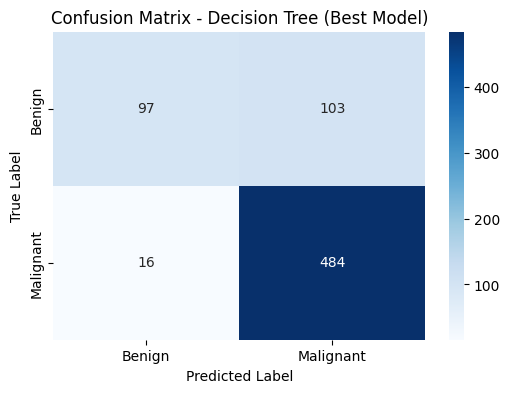

In [19]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Decision Tree (Best Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.48      0.62       200
   Malignant       0.82      0.97      0.89       500

    accuracy                           0.83       700
   macro avg       0.84      0.73      0.76       700
weighted avg       0.83      0.83      0.81       700



In [21]:
dt_shallow = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=42)
dt_deep = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)

# Fit and predict
dt_shallow.fit(X_train, y_train)
dt_deep.fit(X_train, y_train)

y_test_shallow = dt_shallow.predict(X_test)
y_test_deep = dt_deep.predict(X_test)

In [22]:
# Metrics for comparison
shallow_f1 = f1_score(y_test, y_test_shallow)
shallow_accuracy = accuracy_score(y_test, y_test_shallow)
shallow_recall = recall_score(y_test, y_test_shallow)

deep_f1 = f1_score(y_test, y_test_deep)
deep_accuracy = accuracy_score(y_test, y_test_deep)
deep_recall = recall_score(y_test, y_test_deep)

best_f1 = test_f1
best_accuracy = test_accuracy
best_recall = test_recall

In [23]:
# Create a comparison DataFrame
comparison = pd.DataFrame({
    'Model Variety': ['Shallow (depth=3)', 'Deep Untuned', 'Tuned Best'],
    'Accuracy': [shallow_accuracy, deep_accuracy, best_accuracy],
    'F1-Score': [shallow_f1, deep_f1, best_f1],
    'Recall': [shallow_recall, deep_recall, best_recall]
})
print("\nModel Varieties Comparison:")
print(comparison)


Model Varieties Comparison:
       Model Variety  Accuracy  F1-Score  Recall
0  Shallow (depth=3)  0.801429  0.873291   0.958
1       Deep Untuned  0.837143  0.894640   0.968
2         Tuned Best  0.830000  0.890524   0.968
